#  Generating Images from Text Inputs
## First Step: Creating Text Embeddings 

### by: Melahat Tayli

<h2> Table of contents </h2>
<h3> 1. Problem Statement </h3>
<h3> 2. Summary of Acquiring the Data </h3>
<h3> 3. Loading the Data into Pandas DataFrame </h3>

    3.1 Define paths to all the data files
    
    3.2 Load image name and image ids
    
    3.3 Load train-test split and image ids
    
    3.4 Load class name and class ids
    
    3.5 Load image id and class ids
    
    3.6 Load image id and bounding boxes
    
    3.7 Load image id, text and image arrays
    
    3.8 Merge dataframes using image ids

<h3> 4. Visualization/EDA/Analysis </h3>

    4.1. Inspect the overall dataset
        4.1.1 Check for missing data
    
    4.2. Check class imbalance  
        4.2.1. Check number of bird classes (species)
        4.2.2. Check number of data points in each class
        4.2.3. Check number of data points in training/test
         
    4.3. Explore and preprocess the image data    
        4.3.1. Check image dimensions 
        4.3.2. Check if all the images are rgb
        4.3.3. Crop images to their bounding boxes
        4.3.4. Set all images to same size
        4.3.5. Set image pixel values between -1 to 1
    
    4.4. Explore and preprocess the text data        
        4.4.1 Check the number of captions (sentences) for each image
        4.4.2 Clean the text data in each row
        4.4.3 Find the unique words (vocab size) in all text data
        4.4.4 Explore the distribution of words in text data
        4.4.5 Explore the distribution of text length in text data
            4.4.5.1 Find the maximum text length (maxlen)
            4.4.5.2 Visualize frequency of words per text data point

<h3> 5. Text to text embedding </h3>

     5.1 use word2vec    
        5.1.1 Vectorize words using word2vec
            5.1.1.1 Visualize some of the word embeddings obtained by word2vec
        5.1.2 Create an embedding matrix
            5.1.2.1 Padding
            5.1.2.2 Replace rare words
            5.1.2.3 Turn text data into their index representation
            5.1.2.4 Create embedding matrix from sequences by using word embeddings 
            

        

       

In [ ]:
# RUN THIS CELL to style markdowns
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<h1> 1. Problem Statement </h1>

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;">  

OpenAI introduced DALL-E and DALL-E 2, two AI systems that create an image from a prompt of text.

It is vital to understand the underlying architecture and properties of these AI systems and other similar ones.

One of the most popular resarch papers on converting text to images is from Reed et al., “Generative Adversarial Text to Image Synthesis.” 

This project’s goals are to utilize similar networks such as a GAN and diffusion models to create images from text and evaluate their relative performance. 

In this respect, creating text embeddings is a crucial step. In this part of the project, this notebook gives a detailed exploratory data analysis and creating an embedding from text inputs to feed into neural network. For training and test data, these embeddings are matched to respecting preprocessed images.

<h1> 2. Summary of Acquiring the Data </h1>

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;">  
    
A major part of the data was downloaded from the Caltech Vision Lab page (http://www.vision.caltech.edu/datasets/cub_200_2011/). This part of the data is stored within many directories and sub-directories. Mainly, there are 3 main directories. These are:

1. images/
2. parts/
3. attributes/

Specifically, the “images” directory contains the bird images in .jpg format. These images are organized into many subdirectories. The subdirectory names give information about the types of bird species. There are in total 11,788 images for 200 unique species.

The “parts” directory contains information about the birds’ part names such as beaks, feet, eyes, etc. There are 15 unique part names. Location information about 15 unique body parts are also described in x and y coordinates. The “attributes” directory contains information about the attribute names, attribute IDs, as well as certainty values. Certainty specifies the sureness about the existence of an attribute
contained in the file. There are 4 certainty levels: “not visible”, “guessing”, “ probably”, “definitely”. There are 312 unique attribute names. Example of an attribute name is: “has_wing_pattern::striped”. 

For this project, we don't need parts and attributes information.

Apart from above directories, there are 5 text files:

    1. images.txt
    2. train_text.txt
    3. bounding_boxes.txt
    4. classes.txt
    5. image_class_labels.txt

The bounding_boxes file contains information about the location of the image. The images file has image names, and the classes file has class names. The train_text file points out which data is in training or test. The image_class_labels has class ids. All these .txt files also have image_ids. So, all this information could be merged by using image ids.


The captions were downloaded from https://huggingface.co/datasets/alkzar90/CC6204-Hackaton-Cub-Dataset/resolve/main/data/text.zip. There are ten captions (sentences) for each image.


<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;"> 
    
#### 2.1 Imports and helper functions

In [2]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np


import os
import cv2 
import glob
import re
from PIL import Image

import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

from textwrap import wrap
from tqdm import tqdm
import math
from IPython import display

import tensorflow as tf
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Conv2DTranspose, LeakyReLU, BatchNormalization, Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# from einops import rearrange
# from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

# configure the GPU
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
session = tf.compat.v1.Session(config=config)

[nltk_data] Downloading package punkt to /home/u_11530095/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2023-05-08 21:27:20.044076: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-08 21:27:21.433531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 21:27:24.882909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/envs/cs109b/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons 

<h1> 3. Loading the Data into Pandas DataFrame</h1>

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;">  
    
Our dataset is downloaded in the form of many subdirectories and 5 .txt files. 

In this step, we will upload each subdirectory one by one and explore them.


In [4]:
# unzip text dataset
import zipfile
if not os.path.isdir('./CUB_200_2011/text'):
    with zipfile.ZipFile('./text.zip', 'r') as zip_ref:
        zip_ref.extractall('./CUB_200_2011/')
else:
    print("text files already available!!")

text files already available!!


In [5]:
if not os.path.isdir('./CUB_200_2011/images'):
    with zipfile.ZipFile('./images.zip', 'r') as zip_ref:
        zip_ref.extractall('./CUB_200_2011/')
else:
    print("image files already available!!")

image files already available!!


In [6]:
os.getcwd()       

'/home/u_31500907'

<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;"> 

#### 3.1 Define paths to all the data files

In [7]:
# define paths to all data as well as column names for the data atrributes

path_images = "CUB_200_2011/images.txt"
columns_images = ['image_id', 'image_name']

path_train_test_split = "CUB_200_2011/train_test_split.txt"
columns_train_test_split = ['image_id', 'is_training_image']

path_classes = "CUB_200_2011/classes.txt"
columns_classes = ['class_id','class_name']

path_image_class_labels = "CUB_200_2011/image_class_labels.txt"
columns_image_class_labels = ['image_id', 'class_id']

path_bounding_boxes = "CUB_200_2011/bounding_boxes.txt"
columns_bounding_boxes = ['image_id', 'box_x', 'box_y', 'box_width', 'box_height']

path_image_data = "CUB_200_2011/images"

# text info found on https://huggingface.co/datasets/alkzar90/CC6204-Hackaton-Cub-Dataset/resolve/main/data/text.zip
path_text_data = "CUB_200_2011/text" 


<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;"> 

#### 3.2 Load image name and image IDs

In [8]:
df_images = pd.read_csv(path_images, sep=" ", header=None)
df_images.columns = columns_images
df_images.head()

image_id                                         image_name
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...

In [9]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    11788 non-null  int64 
 1   image_name  11788 non-null  object
dtypes: int64(1), object(1)
memory usage: 184.3+ KB


<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;"> 

#### 3.3 Load train-test split and image IDs

In [10]:
df_train_test_split = pd.read_csv(path_train_test_split, sep=" ", header=None)
df_train_test_split.columns = columns_train_test_split
df_train_test_split.head()

image_id  is_training_image
0         1                  0
1         2                  1
2         3                  0
3         4                  1
4         5                  1

In [11]:
df_train_test_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   image_id           11788 non-null  int64
 1   is_training_image  11788 non-null  int64
dtypes: int64(2)
memory usage: 184.3 KB


<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;"> 

#### 3.4 Load class name and class IDs

In [12]:
df_classes = pd.read_csv(path_classes, sep=" ", header=None)
df_classes.columns = columns_classes
df_classes.head()

class_id                  class_name
0         1  001.Black_footed_Albatross
1         2        002.Laysan_Albatross
2         3         003.Sooty_Albatross
3         4       004.Groove_billed_Ani
4         5          005.Crested_Auklet

In [13]:
df_classes.shape

(200, 2)

<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;"> 

#### 3.5 Load image id and class IDs

In [14]:
df_image_class_labels = pd.read_csv(path_image_class_labels, sep=" ", header=None)
df_image_class_labels.columns = columns_image_class_labels
df_image_class_labels.head()

image_id  class_id
0         1         1
1         2         1
2         3         1
3         4         1
4         5         1

In [15]:
df_image_class_labels.shape

(11788, 2)

<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;"> 

#### 3.6 Load image IDs and bounding boxes

In [16]:
df_bounding_box = pd.read_csv(path_bounding_boxes, sep=" ", header=None)
df_bounding_box.columns = columns_bounding_boxes
df_bounding_box.head()

image_id  box_x  box_y  box_width  box_height
0         1   60.0   27.0      325.0       304.0
1         2  139.0   30.0      153.0       264.0
2         3   14.0  112.0      388.0       186.0
3         4  112.0   90.0      255.0       242.0
4         5   70.0   50.0      134.0       303.0

In [17]:
df_bounding_box.shape

(11788, 5)

In [18]:
df_bounding_box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    11788 non-null  int64  
 1   box_x       11788 non-null  float64
 2   box_y       11788 non-null  float64
 3   box_width   11788 non-null  float64
 4   box_height  11788 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 460.6 KB


<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;"> 
    
         
#### 3.7 Load image IDs, text and image arrays

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;">  
    
Here, we have to remember that all of the image paths include the names of the images (image name = bird name).

Text files also have the same structure with the image files. All of the text paths include the name of the images.

One of the dataframes created above includes image names and image ids. This dataframe is called df_image. Let's create a dictionary which maps image names to image ids. 

Afterwards, we can map each image and text to their image ids by leveraging image paths. Then, image and text data could be merged by leveraging the image ids.

In [19]:
# paths of text files
text_path_files = sorted(glob.glob(os.path.join(path_text_data, "*", "*.txt")))
len(text_path_files)
print(f"There are {len(text_path_files)} text paths\n")
print("The first 10 paths to text files are:")
text_path_files[:10]

There are 11788 text paths

The first 10 paths to text files are:


['CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.txt',
 'CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.txt',
 'CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0003_796136.txt',
 'CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0005_796090.txt',
 'CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.txt',
 'CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0007_796138.txt',
 'CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0008_796083.txt',
 'CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.txt',
 'CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.txt',
 'CUB_200_2011/text/001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.txt']

#### Text paths include image names

In [20]:
#paths of image files
img_path_files = sorted(glob.glob(os.path.join(path_image_data, "*", "*.jpg")))
print(f"There are {len(img_path_files)} image paths\n")
print("The  first 10 paths to image files are:")
img_path_files[:10]

There are 11788 image paths

The  first 10 paths to image files are:


['CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg',
 'CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg',
 'CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0003_796136.jpg',
 'CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0005_796090.jpg',
 'CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg',
 'CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0007_796138.jpg',
 'CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0008_796083.jpg',
 'CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg',
 'CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg',
 'CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg']

#### Image paths include image names

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;">  
    
#### Let's create a dictionary which maps image names to image ids using df_images.
##### Using this dictionary, we can have map images and texts to image ids.

In [21]:
# create a dictionary for image_name to image_id
image_ids = df_images['image_id'].values
image_names = df_images['image_name'].values
img_name_to_id = dict(zip(image_names, image_ids))
i=0

print("Some examples of image names and their corresponding ids:")
for image_name in img_name_to_id:
    print(f"\t{image_name}:  {img_name_to_id[image_name]}")
    i += 1
    if i == 10:
        break         

Some examples of image names and their corresponding ids:
	001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg:  1
	001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg:  2
	001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg:  3
	001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg:  4
	001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg:  5
	001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg:  6
	001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg:  7
	001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg:  8
	001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg:  9
	001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg:  10


In [22]:
# create a data frame which has text data and images as numpy arrays
# for sanity check include the image_ids 

# all image paths start with 'CUB_200_2011/images/'. 
# So we need to remove this to obtain the image names from the image paths
image_name_start_index = len('CUB_200_2011/images/') 

# create an empty dataframe
df_text_image = pd.DataFrame(columns=["image_id", "text", "image_array"]) 

for img_path, text_path in zip(img_path_files, text_path_files):
    image_name = img_path[image_name_start_index:] # get image name from image path
    img_id = img_name_to_id[image_name] # get image id by using img_name_to_id dictionary
    
    # Sanity check to ensure that pairs of text and image are correct
    if os.path.basename(img_path).replace(".jpg", "") == os.path.basename(text_path).replace(".txt", ""):
        with open(text_path) as f:
            text= f.read()
        img = imread(img_path)
            
        df_text_image.loc[len(df_text_image.index)] = [img_id, text, img]

In [23]:
df_text_image

image_id                                               text   
0            39  the medium sized bird has a dark grey color, a...  \
1             3  the bird has head and beak proportional to its...   
2            54  the large brown bird has a big bill and white ...   
3            28  the gray bird has a light grey head and grey w...   
4            14  this large bird has a buff colored belly, a lo...   
...         ...                                                ...   
11783     11745  a small yellow bodied bird with a white creste...   
11784     11760  this little bird has a white belly, yellow bre...   
11785     11750  the small bird has a greenish yellow appearanc...   
11786     11741  a small bird with a yellow chest and black aro...   
11787     11765  this small bird has a yellow breast and neck w...   

                                             image_array  
0      [[[178, 182, 181], [177, 181, 180], [177, 181,...  
1      [[[113, 133, 160], [109, 130, 157], [116, 140,...  
2      [[[175, 177, 163], [173, 175, 161], [170, 172,...  
3      [[[129, 154, 184], [128, 153, 183], [128, 151,...  
4      [[[189, 195, 207], [194, 198, 210], [199, 203,...  
...                                                  ...  
11783  [[[168, 186, 226], [167, 185, 225], [167, 185,...  
11784  [[[68, 108, 48], [72, 103, 46], [67, 111, 32],...  
11785  [[[48, 55, 21], [50, 58, 21], [55, 63, 22], [6...  
11786  [[[186, 186, 196], [184, 184, 194], [184, 184,...  
11787  [[[107, 115, 58], [107, 115, 58], [107, 114, 6...  

[11788 rows x 3 columns]

<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;"> 

#### 3.8 Merge dataframes using image IDs

In [24]:
df = pd.merge(df_images, df_train_test_split, on='image_id', how='inner') 
df = pd.merge(df, df_image_class_labels, on='image_id', how='inner') 
df = pd.merge(df, df_bounding_box, on='image_id', how='inner')
df = pd.merge(df, df_text_image, on='image_id', how='inner') 
df.head()

image_id                                         image_name   
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...  \
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...   
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...   
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...   
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...   

   is_training_image  class_id  box_x  box_y  box_width  box_height   
0                  0         1   60.0   27.0      325.0       304.0  \
1                  1         1  139.0   30.0      153.0       264.0   
2                  0         1   14.0  112.0      388.0       186.0   
3                  1         1  112.0   90.0      255.0       242.0   
4                  1         1   70.0   50.0      134.0       303.0   

                                                text   
0  light tan colored bird with a white head and a...  \
1  the wings are brown, long and narrow, and have...   
2  the bird has head and beak proportional to its...   
3  the bird has two large wingbars that are grey ...   
4  this flying bird has long brown wings and a bl...   

                                         image_array  
0  [[[6, 1, 0], [1, 0, 4], [0, 4, 7], [0, 7, 3], ...  
1  [[[0, 0, 0], [0, 0, 0], [4, 4, 4], [7, 7, 7], ...  
2  [[[113, 133, 160], [109, 130, 157], [116, 140,...  
3  [[[203, 203, 211], [203, 203, 211], [203, 203,...  
4  [[[243, 245, 244], [244, 246, 245], [245, 247,...

In [25]:
# clear memory
df_text_image=None
df_train_test_split=None
df_bounding_box=None
df_image_class_labels=None


<h1> 4. Visualization/EDA/Analysis </h1>

<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;">  
    
#### 4.1. Inspect the overall dataset

In [26]:
df.head()

image_id                                         image_name   
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...  \
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...   
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...   
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...   
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...   

   is_training_image  class_id  box_x  box_y  box_width  box_height   
0                  0         1   60.0   27.0      325.0       304.0  \
1                  1         1  139.0   30.0      153.0       264.0   
2                  0         1   14.0  112.0      388.0       186.0   
3                  1         1  112.0   90.0      255.0       242.0   
4                  1         1   70.0   50.0      134.0       303.0   

                                                text   
0  light tan colored bird with a white head and a...  \
1  the wings are brown, long and narrow, and have...   
2  the bird has head and beak proportional to its...   
3  the bird has two large wingbars that are grey ...   
4  this flying bird has long brown wings and a bl...   

                                         image_array  
0  [[[6, 1, 0], [1, 0, 4], [0, 4, 7], [0, 7, 3], ...  
1  [[[0, 0, 0], [0, 0, 0], [4, 4, 4], [7, 7, 7], ...  
2  [[[113, 133, 160], [109, 130, 157], [116, 140,...  
3  [[[203, 203, 211], [203, 203, 211], [203, 203,...  
4  [[[243, 245, 244], [244, 246, 245], [245, 247,...

In [27]:
df.columns.values

array(['image_id', 'image_name', 'is_training_image', 'class_id', 'box_x',
       'box_y', 'box_width', 'box_height', 'text', 'image_array'],
      dtype=object)

##### The bounding box ('box_x', 'box_y', 'box_width', 'box_height) columns will be used to crop images


#### 4.1.1 Check for missing data

In [28]:
df.isna().sum()

image_id             0
image_name           0
is_training_image    0
class_id             0
box_x                0
box_y                0
box_width            0
box_height           0
text                 0
image_array          0
dtype: int64

#### There is no missing data, so we do not need to impute/drop

<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;">  

#### 4.2. Check class imbalance
    
    In this part of our data exploration:
    
        1. Find number of bird classes (bird species)
        2. Check number of data points per class
        3. Check the number of training/test samples (dataset points out which data points will be in training or test)
    

#### 4.2.1. Check number of bird classes (species)

In [29]:
# find number of  bird species (number of classes)
n_classes = df['class_id'].nunique()
print(f"There are {n_classes} unique classes in the bird dataset")

There are 200 unique classes in the bird dataset


#### 4.2.2. Check number of data points in each class

In [30]:

n_data_per_class = df.groupby(by=['class_id']).count()['image_name']
n_data_per_class

class_id
1      60
2      60
3      58
4      60
5      44
       ..
196    59
197    60
198    60
199    60
200    60
Name: image_name, Length: 200, dtype: int64

In [31]:
# Display maximum and minimum number of data points in all classes
print(f"maximum number of data points for a class : {max(n_data_per_class)}")
print(f"minimumn number of data points for a class : {min(n_data_per_class)}")

maximum number of data points for a class : 60
minimumn number of data points for a class : 41


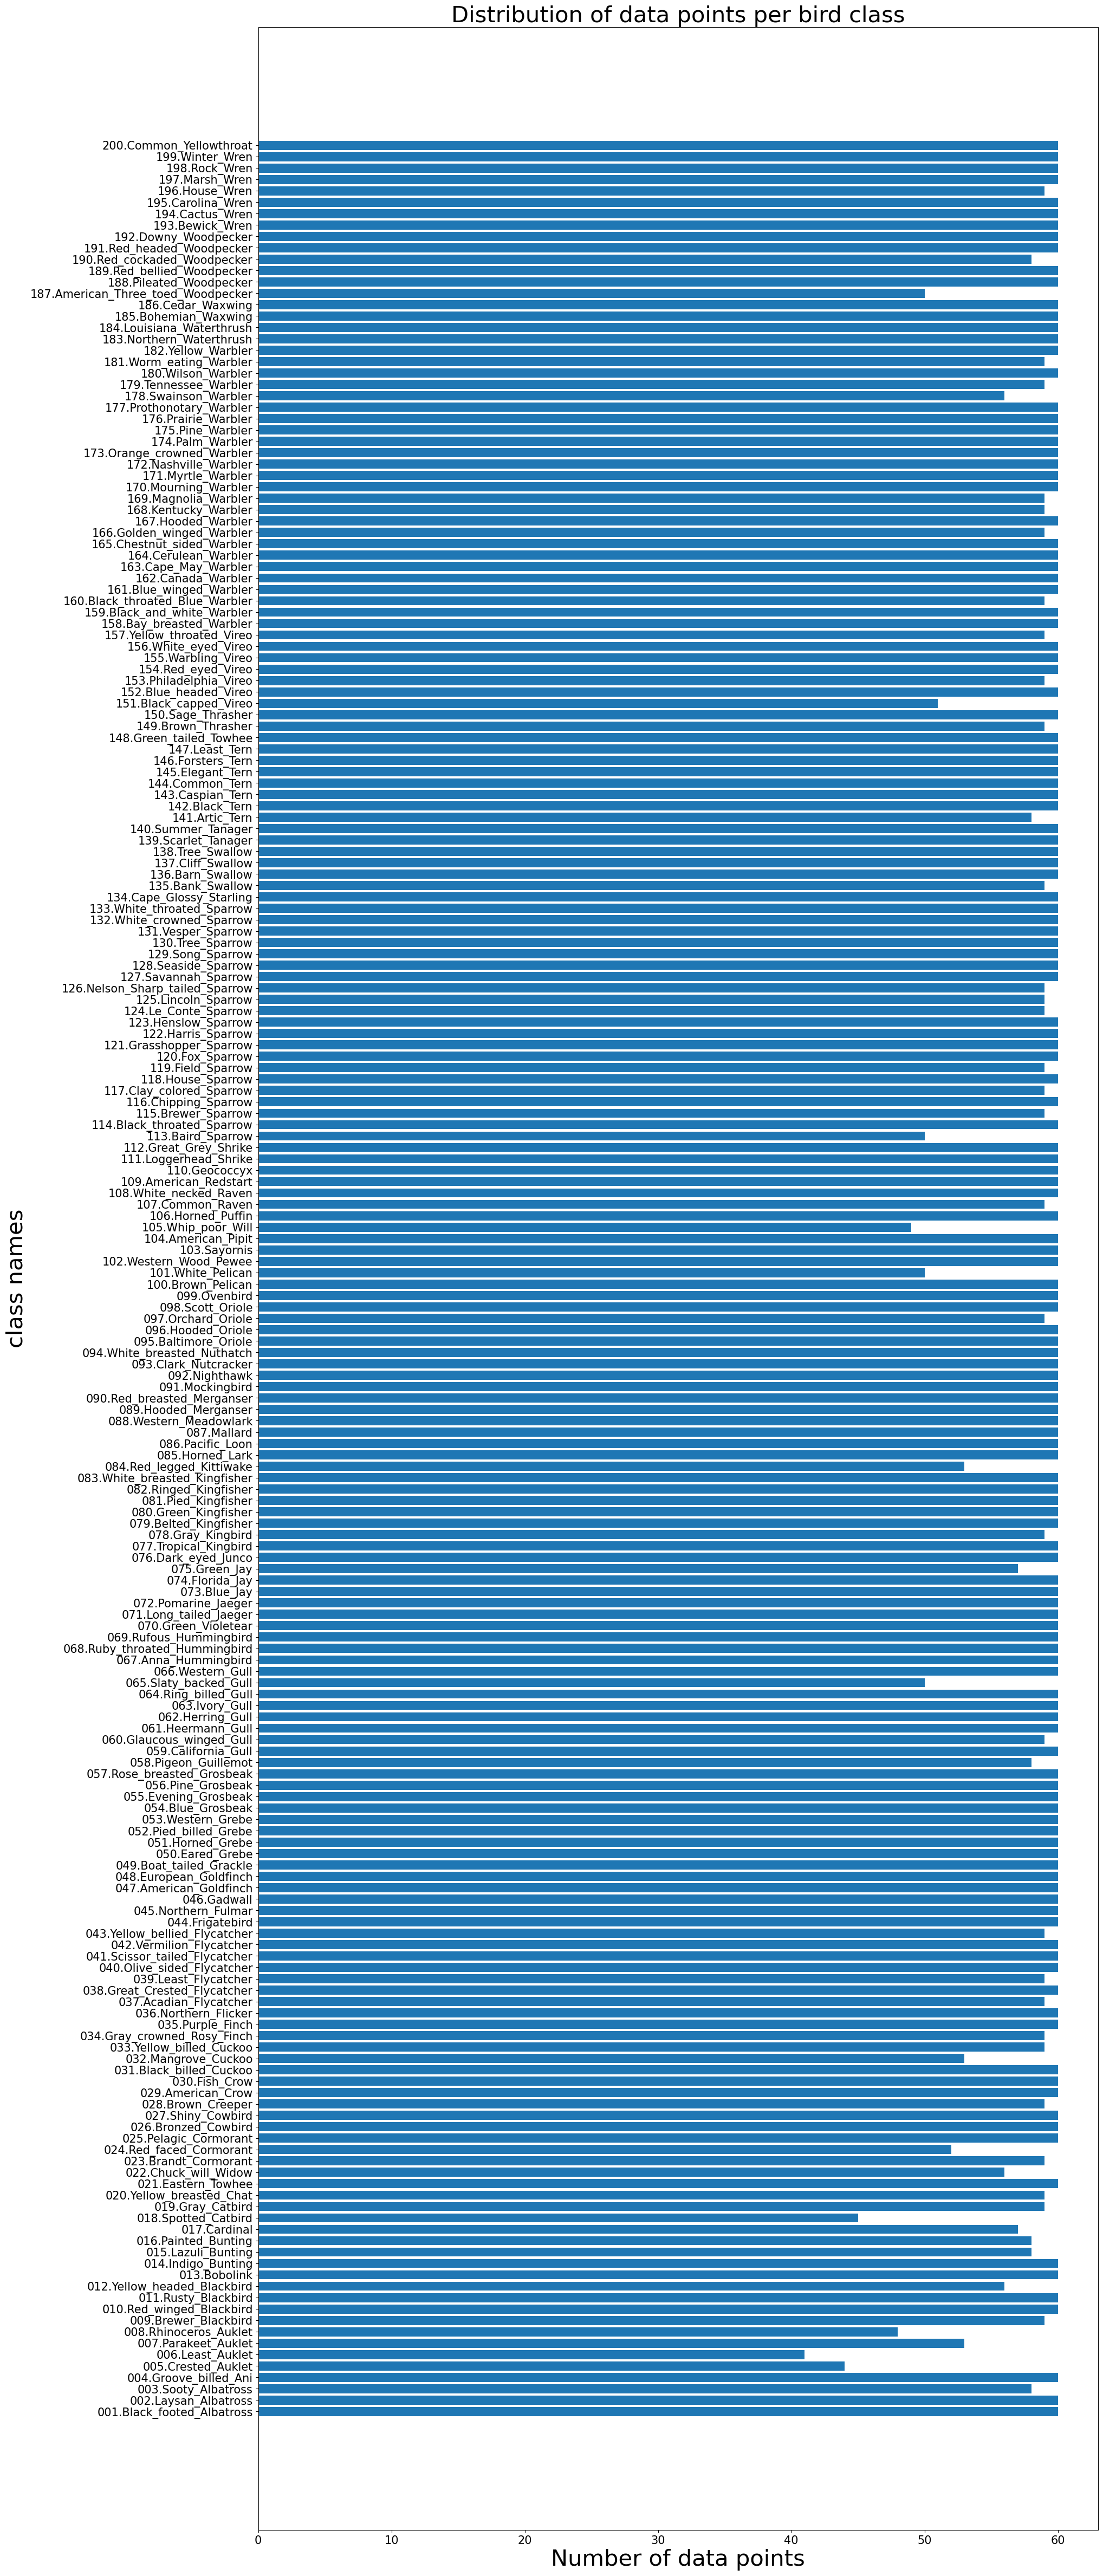

In [32]:
# map class IDs to class name
classid2name = dict(zip(df_classes['class_id'], df_classes['class_name']))

class_names = [classid2name[idx] for idx in n_data_per_class.index]        

# visualize the distribution of data points per bird class
plt.figure(figsize=(20, 60))
plt.barh(class_names, n_data_per_class.values)
plt.xlabel('Number of data points', fontsize=30)
plt.ylabel('class names', fontsize=30)
plt.title("Distribution of data points per bird class", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=15)


#### 4.2.3. Check number of data points in training/test sets

In [33]:
# Display number of training and test data
n_training = df['is_training_image'].sum()
n_test = len(df) - n_training
print(f"Number of data points for training is {n_training}")
print(f"Number of data points for testing is {n_test}")
      

Number of data points for training is 5994
Number of data points for testing is 5794


<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 
    
#### Comments: 

The distribution of number of data points per class is well balanced. Most of the classes have 60 data points. The least number of data point per class is 41.

The number of data points for training and test data is almost the same. However, we will make our own train/test split. The number of test data points will be 10% of all data.


<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;">  

#### 4.3. Explore and preprocess the image data 

In this part, we will explore our images. The main objective is:

    1. Cropping the images to their bounding box dimensions
    2. Resizing images to lower resolution for easier training
    3. Normalizing image pixel values between -1 and 1

#### 4.3.1. Check image dimensions


Text(0.5, 0.98, 'IMAGES FROM CUB DATASET')

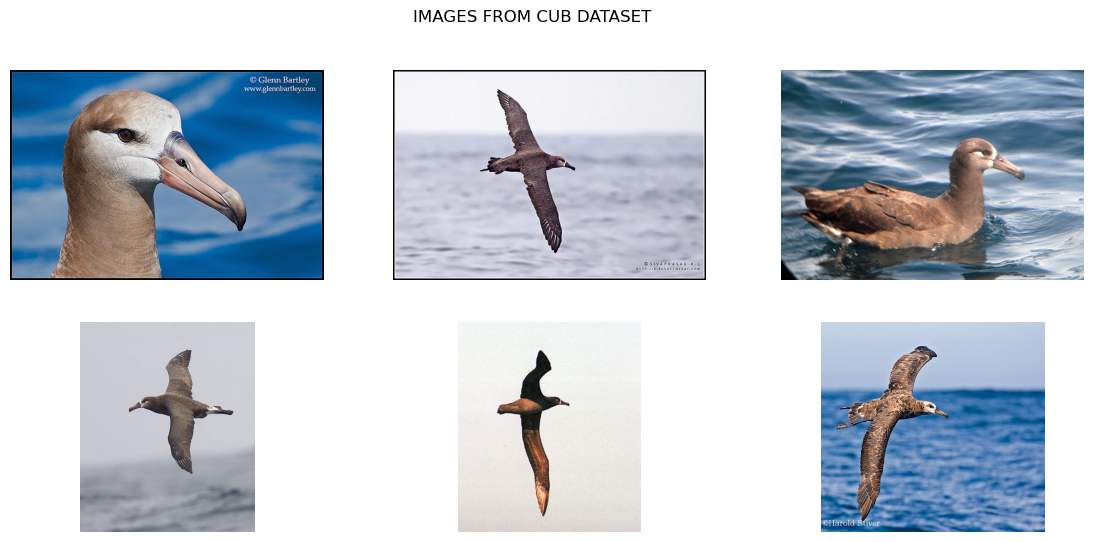

In [34]:
fig, axes = plt.subplots(2,3, figsize=(14,6))
axes = axes.flatten()
i=0
for image in df['image_array']:
    axes[i].imshow(image)
    axes[i].axis('off')
    i +=1
    if i == 6:
        break
fig.suptitle("IMAGES FROM CUB DATASET")

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;">  

#### Above images show that images have different shapes

In [35]:
# print shapes of some of the images
df.loc[:10, 'image_array'].apply(lambda x: (x.shape))

0     (335, 500, 3)
1     (336, 500, 3)
2     (347, 500, 3)
3     (500, 415, 3)
4     (380, 331, 3)
5     (470, 500, 3)
6     (340, 500, 3)
7     (391, 500, 3)
8     (416, 500, 3)
9     (208, 250, 3)
10    (350, 350, 3)
Name: image_array, dtype: object

#### 4.3.2. Check if all the images are colored


In [36]:
shapes = df['image_array'].apply(lambda x: (x.shape))
index_images_3d = shapes.apply(lambda x: len(x) == 3)
print(f"{df.shape[0] - index_images_3d.values.sum()} images are not 3d")

8 images are not 3d


##### There are 8 images which are 1-D. Let's drop them from our dataframe.

In [37]:
df = df[index_images_3d]
df.shape
print(f"there are {df.shape[0]} 3d images");

there are 11780 3d images


#### 4.3.3. Crop images to their bounding boxes

In [38]:
# crop images to their bounding boxes
cropped_images=[]
error_images = [] #images which could not be cropped to their bounding boxes
error_images_idx = []
i = 0
for index, img, offset_height,  offset_width, target_height, target_width in zip(df.index, df.image_array.values, df.box_y.values, df.box_x.values, df.box_height.values, df.box_width.values):
    bbox = np.array([offset_height,  offset_width, target_height, target_width], dtype=np.int64)
    try:
        cropped_image = tf.image.crop_to_bounding_box(img, *bbox)
        cropped_images.append((index, bbox, cropped_image))
    except Exception:
        error_images.append((index, bbox, img))
        error_images_idx.append(index)


2023-05-07 17:19:44.755482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-07 17:19:44.755882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-07 17:19:44.756101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [39]:
len(error_images), len(cropped_images)

(30, 11750)

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;">  

##### 30 images gave an error during cropping to their boxes since their bounding boxes were defined to have a few pixels bigger than the image size. This could be due to human error or a mistake.
##### Let's visualize these images to decide whether to drop them or not.

Text(0.5, 0.98, 'THE IMAGES THAT ARE NOT CROPPED THE THEIR BOUNDING BOXES')

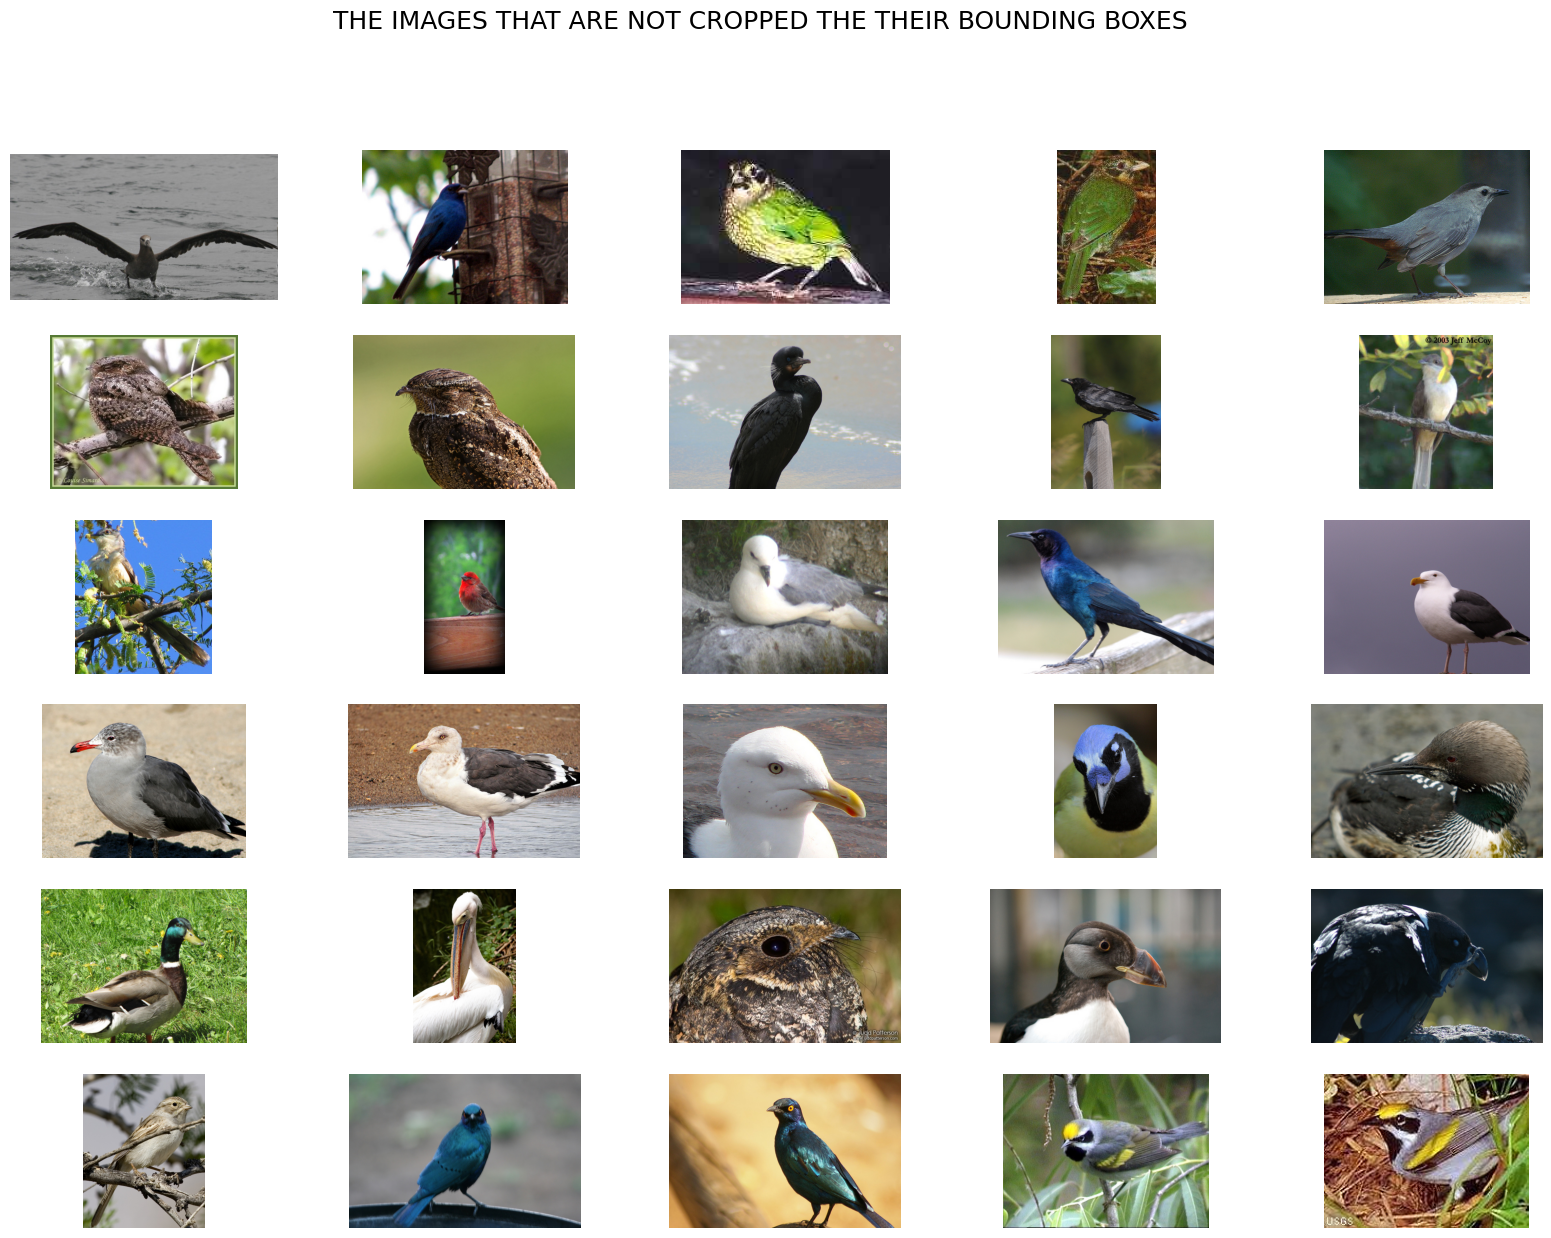

In [40]:
# visualize images that are not cropped to their bounding boxes
fig, ax = plt.subplots(6,5, figsize=(20, 14))
ax = ax.flatten()
i=0
for index, bbox, img in error_images:
    ax[i].imshow(img)
    ax[i].set_axis_off()
    i +=1
fig.suptitle("THE IMAGES THAT ARE NOT CROPPED THE THEIR BOUNDING BOXES", fontsize=18)

##### They contain only bird images and no other objects. So let's keep them in our dataframe.

Text(0.5, 0.98, 'SOME OF THE IMAGES THAT ARE CROPPED THE THEIR BOUNDING BOXES')

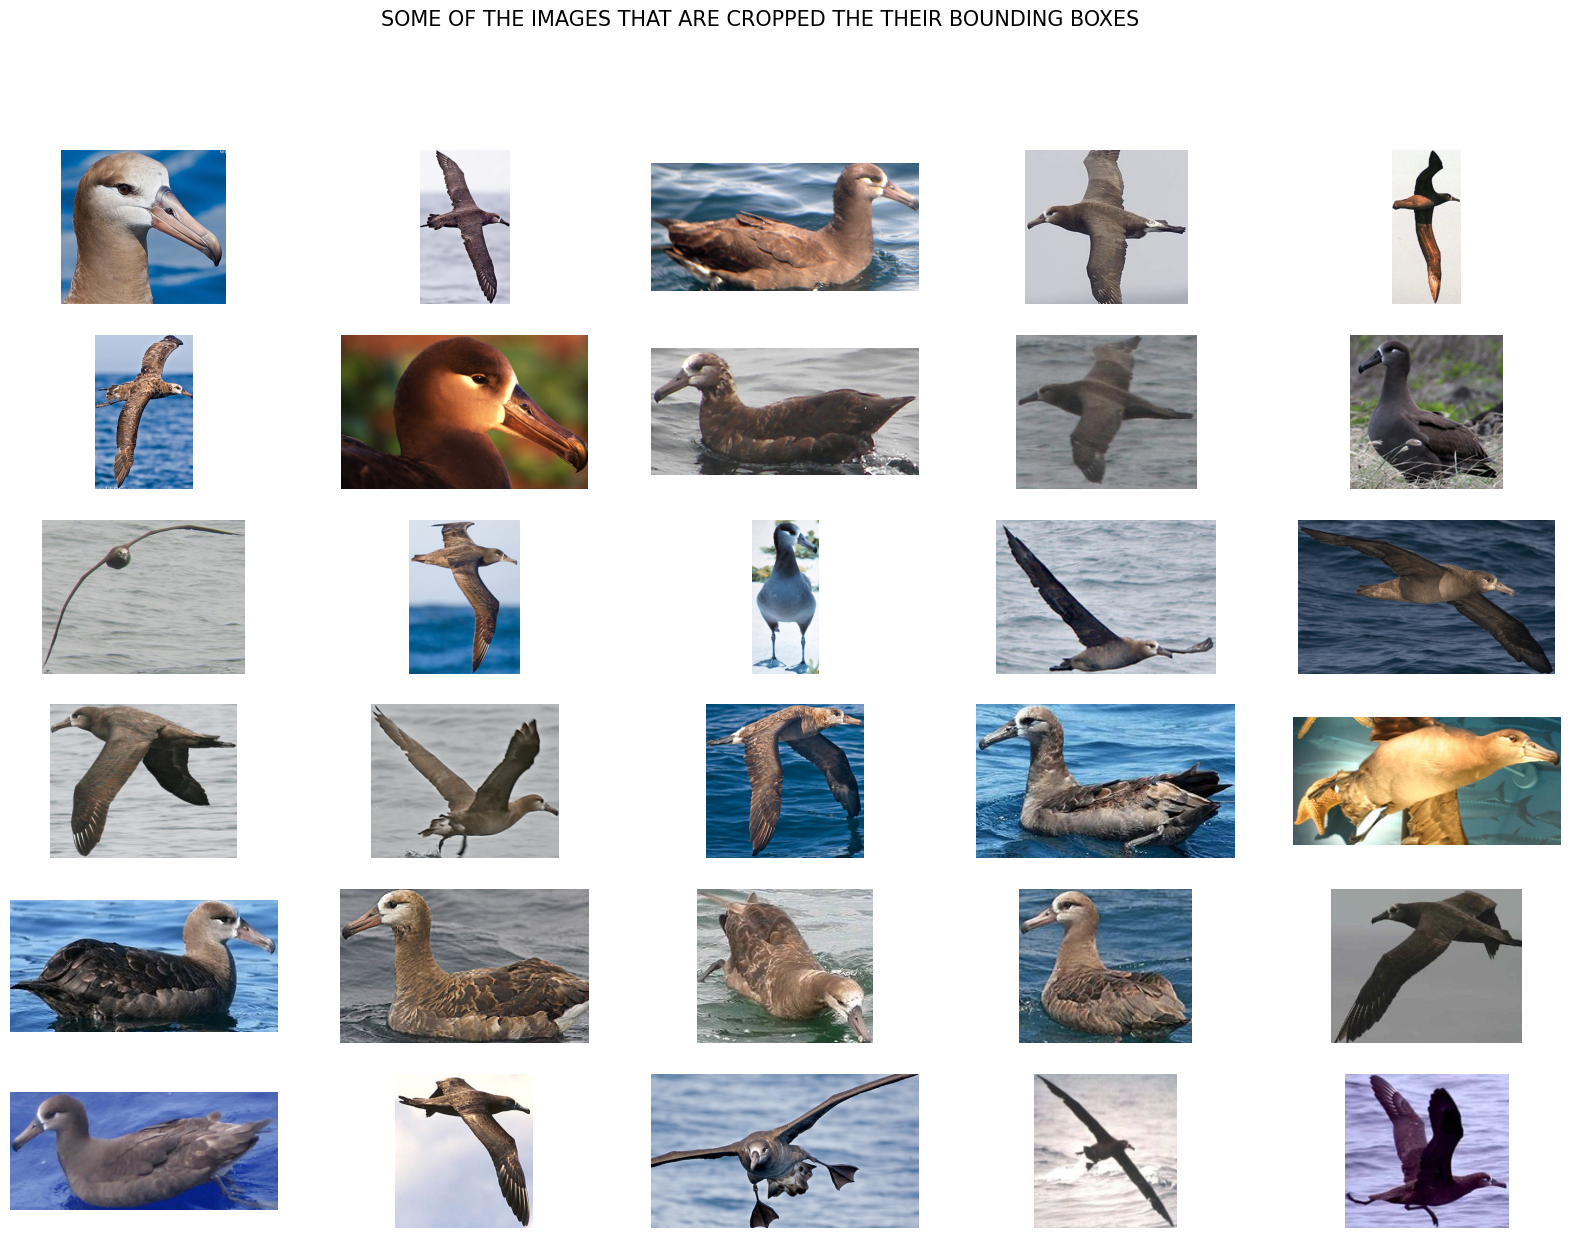

In [41]:
# Visualize images that are cropped to their bounding boxes
fig, ax = plt.subplots(6,5, figsize=(20, 14))
ax = ax.flatten()
i=0
for index, bbox, img in cropped_images:
    ax[i].imshow(img)
    ax[i].set_axis_off()
    i +=1
    if i==30:
        break
fig.suptitle("SOME OF THE IMAGES THAT ARE CROPPED THE THEIR BOUNDING BOXES", fontsize=15)

#### 4.3.4. Set all images to the same size


In [42]:
# set image_array shape
target_img_height = 128
target_img_width = 128
def resize(img, target_height=64, target_width=64, method='nearest'):
    resized_img = tf.image.resize(img,(target_height, target_width), method)
    return resized_img.numpy()

df['image_array'] = df['image_array'].apply(lambda x: resize(x, target_img_height, target_img_width))

# sanity check if all image arrays have correct shapes
df['image_array'].apply(lambda x: x.shape == (target_img_height, target_img_width, 3)).sum() == df.shape[0]  
                                       

True

#### Visualize cropped and resized images

Text(0.5, 0.98, 'SOME OF THE IMAGES THAT ARE CROPPED AND RESIZED IMAGES')

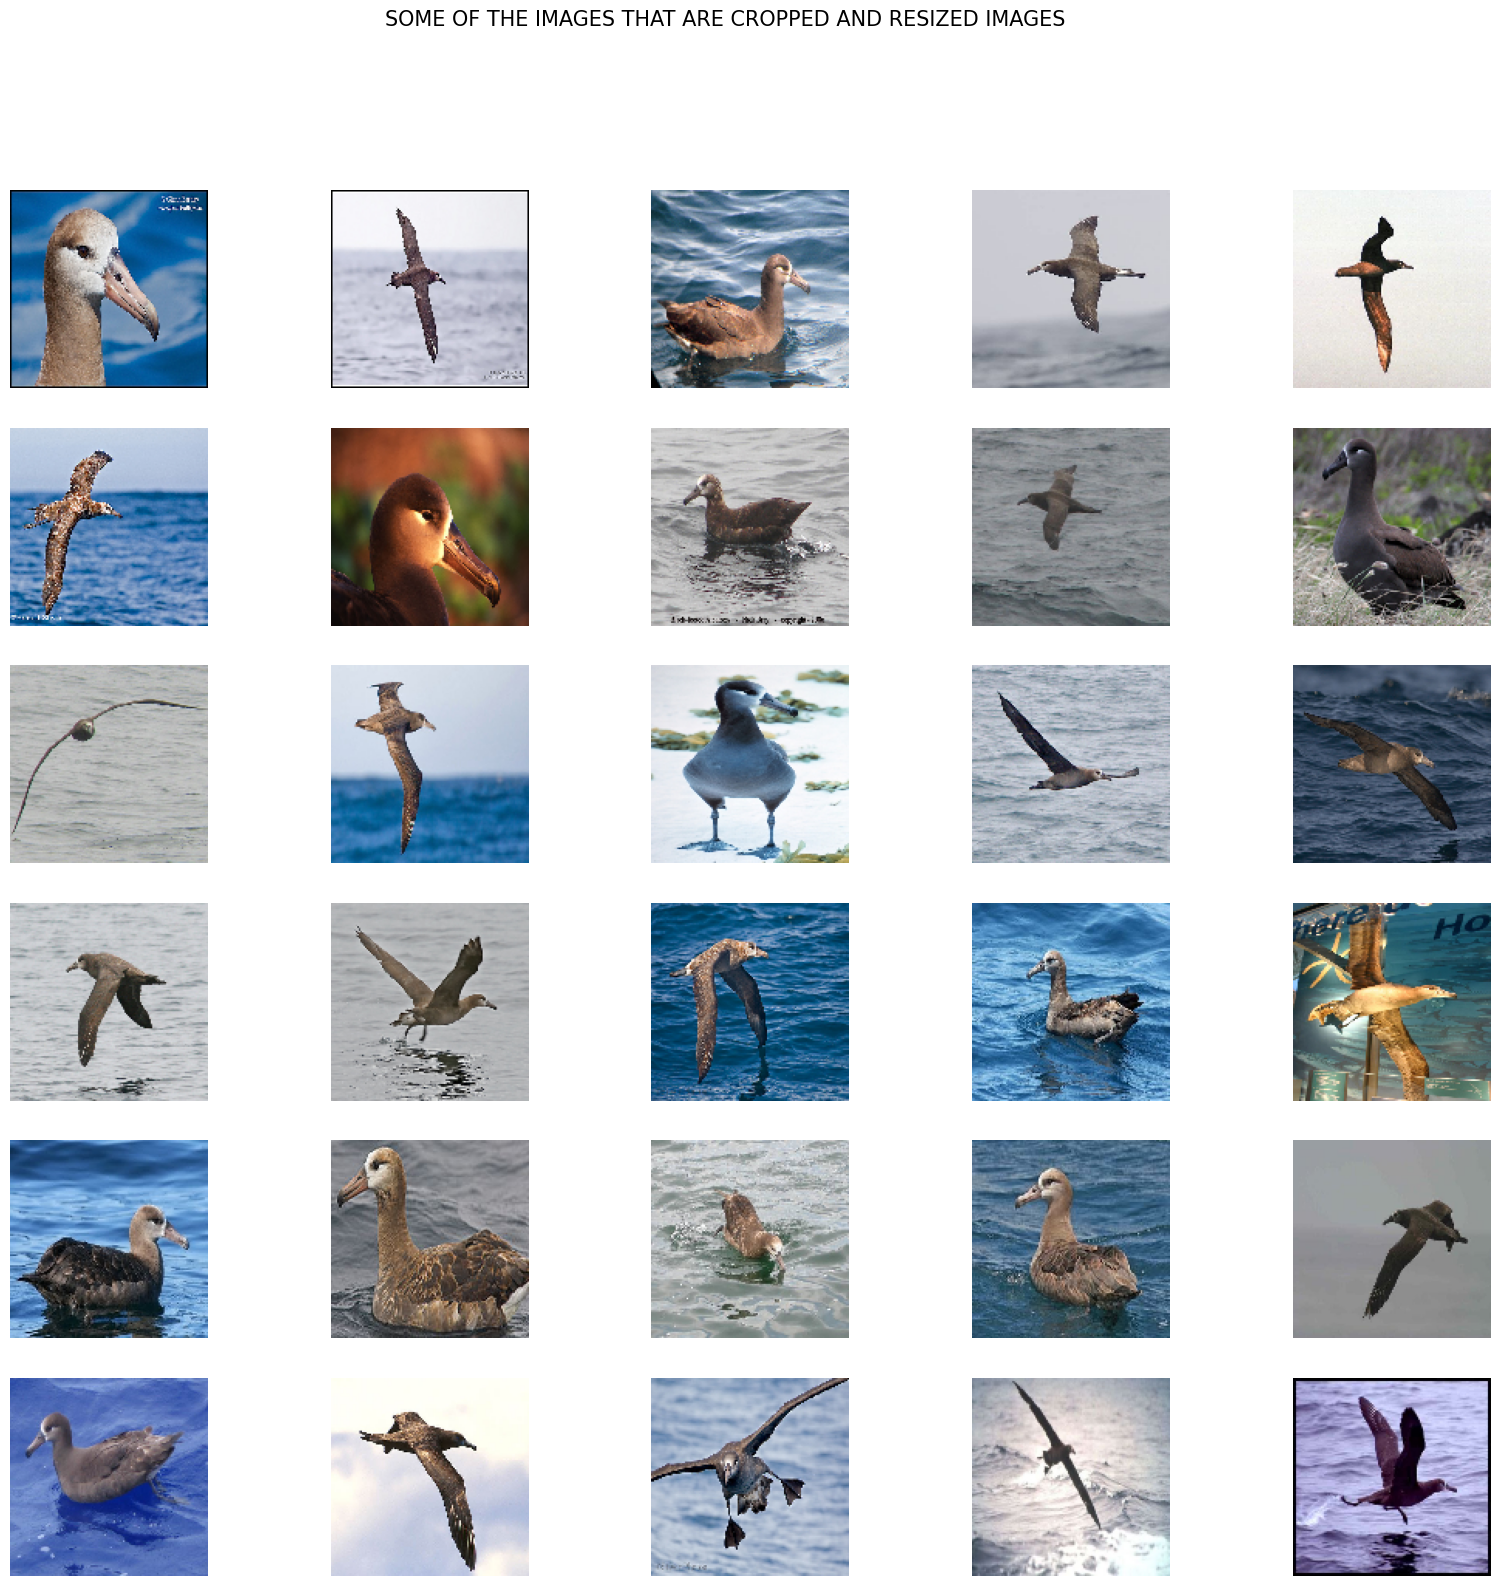

In [43]:
fig, ax = plt.subplots(6,5, figsize=(20, 18))
ax = ax.flatten()
i=0
for img in df['image_array']:
    ax[i].imshow(img)
    ax[i].set_axis_off()
    i +=1
    if i==30:
        break
fig.suptitle("SOME OF THE IMAGES THAT ARE CROPPED AND RESIZED IMAGES", fontsize=15)

#### 4.3.5. Set image pixel values to be between -1 to 1


In [44]:
def preprocess_image(image):
    '''scales image pixels to [-1, 1]'''
    return tf.cast(image, tf.float32) / 127.5 - 1

In [45]:
df['image_array_normalized'] = df['image_array'].apply(lambda x: preprocess_image(x)) # scales all the image arrays between -1 and 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


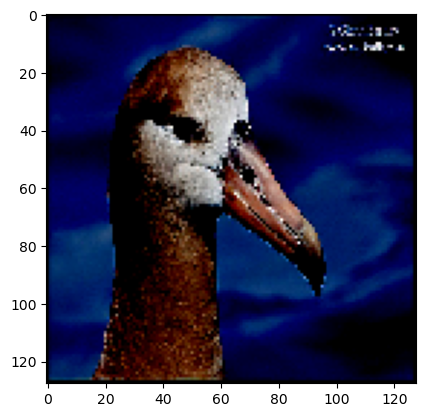

In [46]:
# Visualize one of the scaled images
plt.imshow(df['image_array_normalized'][0])

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;">  
    
#### Comments:
 Images in our dataframe is now all colored, cropped, resized, and scaled. Since we dropped 8 images, the number of data points are 11,780 at this point.
   

<div class="alert alert-success" style="color: #333 ; border-color: #fff1d3; border-width: 2px; border-radius: 5px; padding: 10px;">  
    
#### 4.4. Explore and preprocess the text data 

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;">  

The primary objective here:

    1. Find the number of descriptions (sentences) for each image
    
    2. Find the number of unique words
    
    3. Decide which words to keep (some words used rarely, so we may change them 'UNK' (unkown) tokens).
       So, we can decide our vocab size  which is kept in a variable called n_words
       
    4. Find the maximum text length (maxlen)
    
    5. Vectorize words using word2vec
    
    6. Create an embedding matrix



In [47]:
# check the text data
df['text'][0]

'light tan colored bird with a white head and an orange beak.\nthe bird has a very thick, curved, and beige beak\nthis bird has a long neck that is grainy and a pastel orange/blue narrow beak that droops down at the tip\nthis bird is light brown, has a long hooked bill, and looks dumb.\nthis large white bird has a large curved bill and a brown eye\nthis bird is white with grey and has a long, pointy beak.\nthis bird is white with grey and has a long, pointy beak.\nthe crown of the bird is white, with light brown tones throughout.\nthe crown of the bird has distinctive tones of white and brown throughout.\nthis bird has a long neck and an orange bill\n'

#### 4.4.1 Check the number of descriptions (sentences) for each image

In [48]:
texts = [] # each image caption will be appened to this list
for text_data in df['text']:
    sentences = text_data.split('\n')
    sentences = [x for x in sentences if len(x) > 0]
    texts.append(sentences)
    
# check if each image has the same number of descriptions
n_descriptions =[len(description) for description in texts]
if all(n == n_descriptions[0] for n in n_descriptions):
    print(f"Each image has {n_descriptions[0]} sentences") 


Each image has 10 sentences


#### 4.4.2. Clean the text data in each row

In [49]:
def text_clean(text_raw):
    # convert text to lowercase
    text_lowered = text_raw.lower() 
    # remove punctuations
    punctuation = punctuation = '!",.#$%&()*+-/:;<=>?@[\\]^_`{|}~�'
    text_lowered_no_punc = ''.join([char for char in text_lowered if char not in set(punctuation)]) 
    #replace any number of contiguous whitespace characters with a single space (e.g., '\n\n' -> ' ')
    combine_whitespace = re.compile(r"\s+")
    cleaned_text = combine_whitespace.sub(" ", text_lowered_no_punc).strip() 
    return cleaned_text
df['text_cleaned'] = df['text'].apply(lambda x: text_clean(x))

In [50]:
# display one of the cleaned text data
df['text_cleaned'][0]

'light tan colored bird with a white head and an orange beak the bird has a very thick curved and beige beak this bird has a long neck that is grainy and a pastel orangeblue narrow beak that droops down at the tip this bird is light brown has a long hooked bill and looks dumb this large white bird has a large curved bill and a brown eye this bird is white with grey and has a long pointy beak this bird is white with grey and has a long pointy beak the crown of the bird is white with light brown tones throughout the crown of the bird has distinctive tones of white and brown throughout this bird has a long neck and an orange bill'

#### 4.4.3 Find the unique words (vocab size) in the entire text dataset


In [51]:
all_text = ' '.join(df["text_cleaned"]) #combines the text in each row with a space
unique_words = list(set(all_text.split(' ')))
n_words = len(unique_words)
# Display number of unique words
print("Total number of unique words:", n_words)


Total number of unique words: 7005


<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 
    
##### So, there are 7,005 unique words when we look at all the captions. In general, some words are used often, while some of them used seldomly. Let's investigate which words used commonly or rarely.

#### 4.4.4 Explore the distribution of words in text data


In [52]:
# Find the frequency of each unique word in all text data
freq_dict = {}
all_text_to_word = all_text.split(' ')
for word in all_text_to_word:
    if word in freq_dict:
        freq_dict[word] += 1
    else:
        freq_dict[word] = 1
# sort the dictionary according to frequency of words       
sorted_freq_dict_reverse = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))
sorted_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1]))

In [53]:
# print the rarest 20 words
i=0
print("THE LESS COMMON 20 WORDS")
for elem in sorted_freq_dict:
    print(elem,':', sorted_freq_dict[elem])
    i +=1
    if i == 20:
        break

THE LESS COMMON 20 WORDS
grainy : 1
orangeblue : 1
dumb : 1
incredible : 1
goosesized : 1
waterfowl's : 1
winspan : 1
whitefronted : 1
widewidth : 1
blunttipped : 1
magestic : 1
zoo : 1
exhibit : 1
thcik : 1
feetwings : 1
4x : 1
loarge : 1
offbrown : 1
agrayish : 1
widereacing : 1


<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 
    
##### Incredible only used once in entire text. Words like "loarge" could be spelling mistakes in the original dataset.
##### Let's find the number of words only used once or twice. We could remove them in our vocab.

In [54]:
# print the most frequent 20 words
i=0
for elem in sorted_freq_dict_reverse:
    print(elem,':', sorted_freq_dict[elem])
    i +=1
    if i == 20:
        break

a : 178207
and : 162766
bird : 115351
with : 80447
has : 79697
black : 77562
this : 74219
white : 65030
brown : 42196
is : 41153
beak : 36845
belly : 34107
small : 33078
wings : 31170
yellow : 30682
the : 30159
bill : 28994
long : 21638
grey : 20266
breast : 20108


<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

#####  Words like "a", "and", "with" are used a lot.

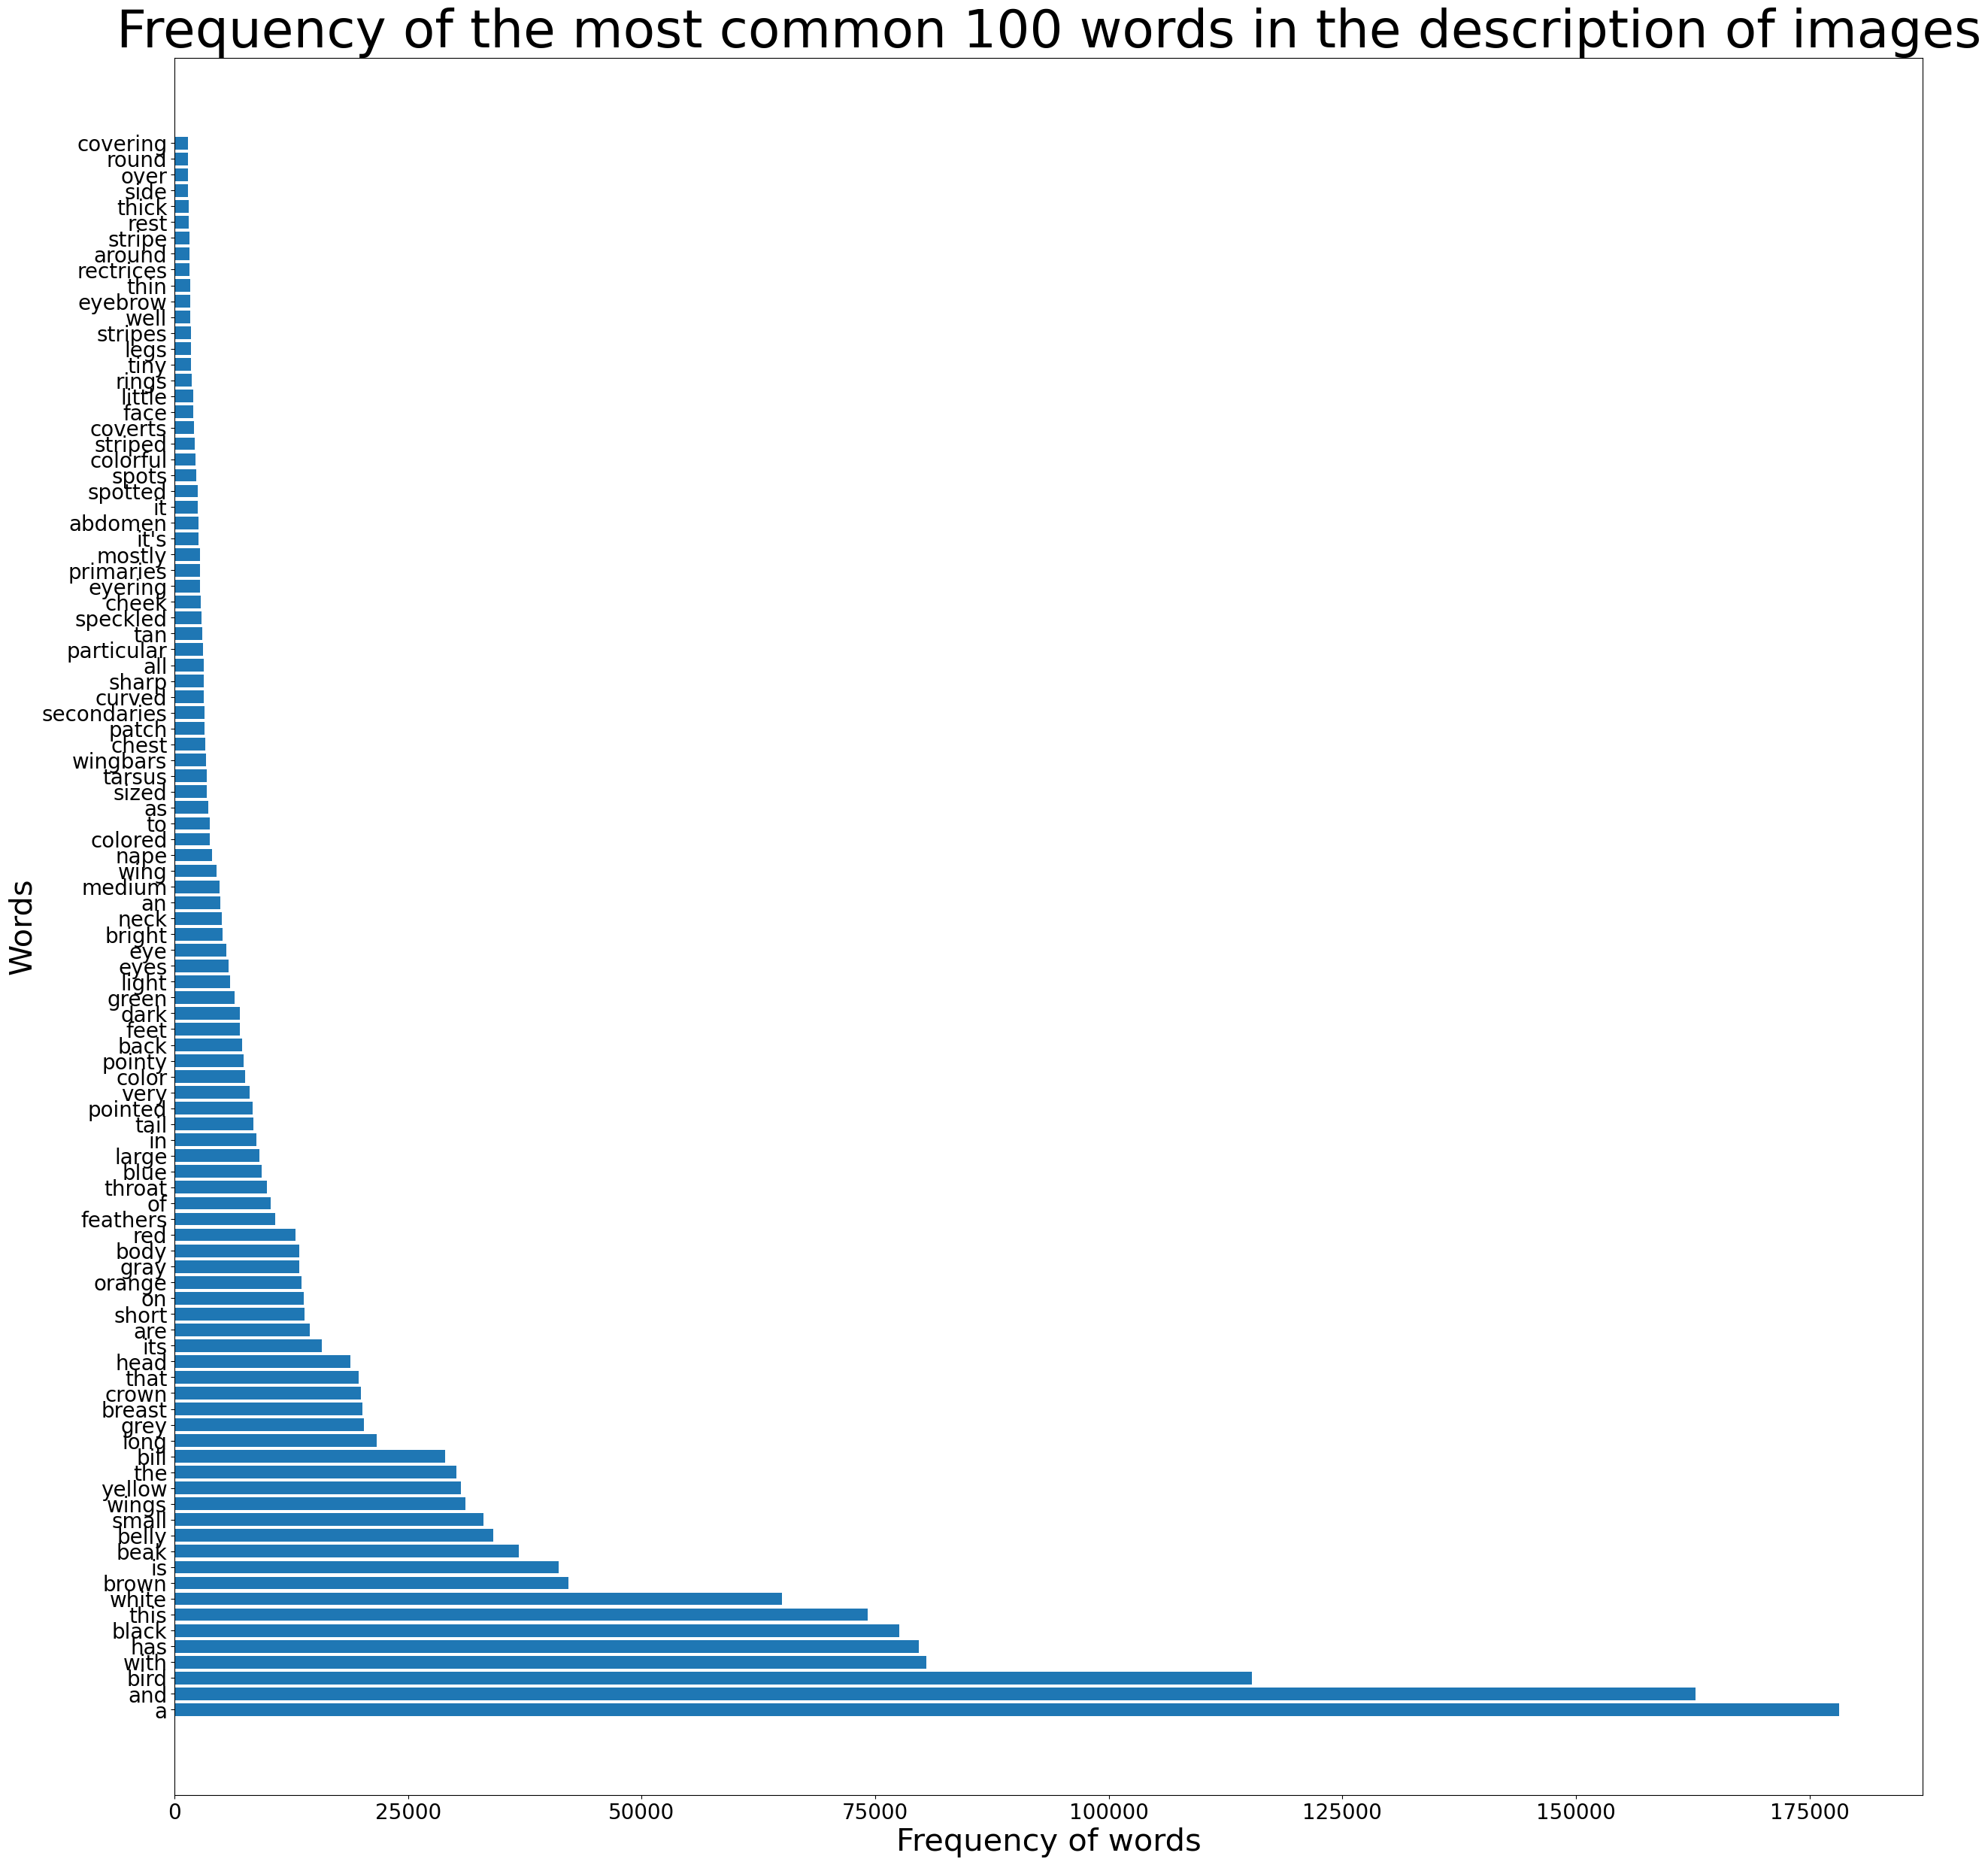

In [55]:
# Visualize the most frequent 100 words in all text data
plt.figure(figsize=(30, 30))
plt.barh(list(sorted_freq_dict_reverse.keys())[:100], list(sorted_freq_dict_reverse.values())[:100])
plt.xlabel('Frequency of words', fontsize=30)
plt.ylabel('Words', fontsize=30)
plt.title("Frequency of the most common 100 words in the description of images", fontsize=50)
plt.tick_params(axis='both', which='major', labelsize=20)

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

##### While the most common word "a" used around 175,000 times in the entire text, the word "round" is used around 1,400 times.
##### "round" is the most used word in the entire text. 
##### So, the frequency of words drops quickly.


#### 4.4.5 Explore the distribution of text length in text data


##### 4.4.5.1 Find the maximum text length

In [56]:
# maximum text length
n_words_all_text = [] # keeps number of words for each text data
for text_data in df['text_cleaned']:
    n_words_all_text.append(len(text_data.split()))
maxlen = max(n_words_all_text)   

# print the maximum text length
print(f"The longest text has {maxlen} words")

The longest text has 242 words


##### 4.4.5.2 Visualize frequency of words per text data point

Text(0.5, 1.0, 'Distribution of number of words per text')

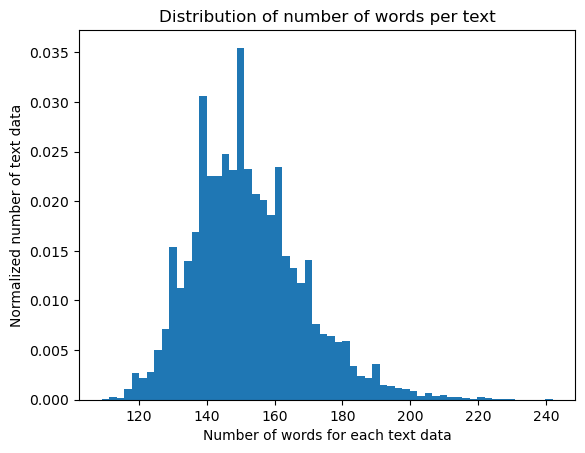

In [57]:
plt.hist(sorted(n_words_all_text, reverse=True), bins=60, density=True);
plt.xlabel("Number of words for each text data")
plt.ylabel("Normalized number of text data")
plt.title("Distribution of number of words per text")

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

#### Above histograms show that many sets of text data are between 130 to 180 words long.


<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

#### Since each text data has 10 sentences, we are curious about the number of words per sentence. Let's explore that.

In [58]:
# the maximum description length (each text has 10 descriptions)
n_max_words = 0
sentence_with_max_words = '' # to see the longest sentence 

# keeps number of words for each sentence (note: each text data has 10 sentences)
n_words_all_sentences = [] 
for sentences in df['text']:
    list_sentences = sentences.split('\n')
    n_words_sentences = []
    for sentence in list_sentences:
        if len(sentence)!=0:
            num_word = len(sentence.split(' '))
            n_words_sentences.append(num_word)
            n_max_words = max(n_max_words, num_word)                             
            if num_word == n_max_words:
                sentence_with_max_words = sentence             
    n_words_all_sentences.append(n_words_sentences)
n_words_all_sentences_flatten = sum(n_words_all_sentences, [])
maxlen_sentence = max(sum(n_words_all_sentences, []))

In [59]:
# print the number of words in longest sentence
print(f"The longest sentence has {maxlen_sentence} words\n")

# display the longest descriptions
print(f"the sentence that has max number of words is:\n{sentence_with_max_words}")

The longest sentence has 65 words

the sentence that has max number of words is:
this is a grayish bird with a stripe of black that extends from the top of its head through the eyes to the tip of the beak and down its neck along with a hint of white in the face, black, white, tan and pink wings, a black and yellow-tipped tail, and a round body with hints of reddish brown in the face and tail.


#### Visualize frequency of words per sentence

Text(0.5, 1.0, 'Distribution of number of words per sentence')

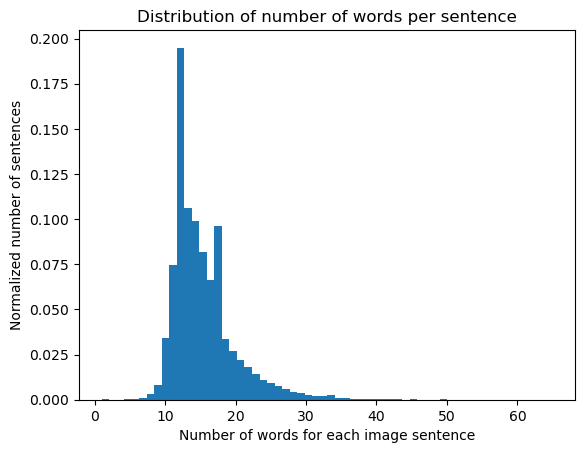

In [60]:
plt.hist(sorted(n_words_all_sentences_flatten, reverse=True), bins=60, density=True);
plt.xlabel("Number of words for each image sentence")
plt.ylabel("Normalized number of sentences")
plt.title("Distribution of number of words per sentence")
           

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 
    
##### Above histograms show that most sentences are between 10 to 20 words long.


<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 
    
#### Comments: 

Each text-data point consists of 10 sentences. In this part, we investigated both text per data point and each sentence seperately. 
    
While the longest sentence have 65 words, most of them have between 10 and 20 words. 

The longest text has 242 words. The distribution of text length (word-wise) peaks around 150, while most of the sentences have between 130 and 180 words.

There are 7,005 unique words in the entire text data. However, many of the words are seen once or twice. Some of these rare words are spelling mistakes. 


<h1> 5. Text to text embedding </h1>

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

##### The primary objective here is to get the text embedding for the text description of each picture.

#####    This can be done through word2vec, or through fine-tuning BERT.


<div class="alert alert-success" style="color: #333; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

#### 5.1 Use Word2Vec


<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

####   5.1.1 Vectorize words using word2vec

   We need to feed sequences to word2vec. Each sequence consists of word tokens.
    
   Firstly, we will prepare sequences in the right format to feed them into word2vec.
   
   Secondly, we will feed each sentence to word2vec to get vectors for each word. 
   
   Lastly, we will prepare an embedding matrix for text.
    

In [61]:
# prepare text data for word2vec
def word_tokens(text):
    tokenized_desc = [] # tokenized descriptions will be appened this list
    for sentences in text:
        sentences = sentences.split('\n')
        splitted_sentences = []
        for sentence in sentences:
            if len(sentence)!=0:
                cleaned_sentence = text_clean(sentence)
                splitted_sentences.append(cleaned_sentence.split(' '))
        tokenized_desc.append(splitted_sentences)
    return sum(tokenized_desc, [])

tokenized_desc = word_tokens(df['text'])

In [62]:
# display 2 tokenize descriptions
print(tokenized_desc[0])
print(tokenized_desc[1])

['light', 'tan', 'colored', 'bird', 'with', 'a', 'white', 'head', 'and', 'an', 'orange', 'beak']
['the', 'bird', 'has', 'a', 'very', 'thick', 'curved', 'and', 'beige', 'beak']


In [63]:
# create a word2 vec model
model_wv = gensim.models.Word2Vec(tokenized_desc, min_count = 1,vector_size=128 , window=3, sg=0, workers=10)

During exploratory analysis, we found that there are 7005 unique words in all of the text data.

In [64]:
# check the number of word vectors in our word2vec model
print(f"there are {len(model_wv.wv.key_to_index.keys())} word vectors in word2vec model")

there are 7005 word vectors in word2vec model


<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

#### 5.1.1.1 Visualize some of the word embeddings obtained by word2vec
    First, we need to make the dimensionalty reduction using t-SNE to visualize word embeddings in 2 dimensional space.

In [65]:
# Find similar words and their corresponding vectors
similar_word_clusters = []
similar_vector_clusters = []
keys = ['black', 'small']
for word in keys:
    similar_words = []
    similar_vectors = []
    for similar_word, _ in model_wv.wv.most_similar(word, topn=3):
        similar_words.append(similar_word)
        similar_vectors.append(model_wv.wv[similar_word])
    similar_word_clusters.append(similar_words)
    similar_vector_clusters.append(similar_vectors)

In [66]:
# Display some of the similar words
print(f"black is similar to: {similar_word_clusters[0]}")
print(f"small is similar to: {similar_word_clusters[1]}")

black is similar to: ['red', 'brown', 'grey']
small is similar to: ['tiny', 'short', 'large']


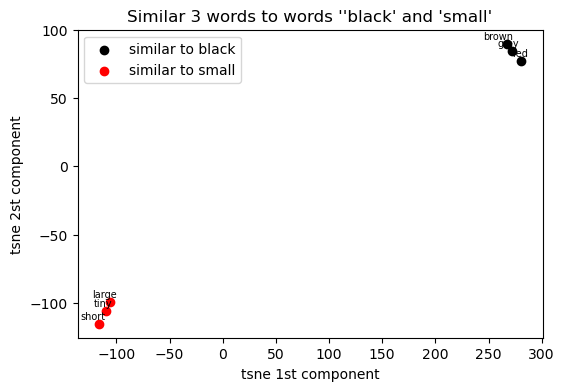

In [67]:
# Display some of the similar word embeddings

# Dimensionality reduction using TSNE
similar_vector_clusters = np.array(similar_vector_clusters)
num_points, n_neighbors, dim_vec = similar_vector_clusters.shape
tsne_2d = TSNE(perplexity=1, n_components=2, init='pca', n_iter=1000, random_state=0)
embeddings_tsne = tsne_2d.fit_transform(similar_vector_clusters.reshape(num_points * n_neighbors, dim_vec))
embeddings_tsne_2d = np.array(embeddings_tsne).reshape(num_points, n_neighbors, 2)

# visualize
plt.figure(figsize=(6, 4))
colors = ['black', 'red']
j=0
for embeddings, similar_words, color in zip(embeddings_tsne_2d, similar_word_clusters, colors):
    x=embeddings[:, 0]
    y=embeddings[:, 1]
    plt.scatter(x, y, c=color, label='similar to '+keys[j])
    j +=1
    for  i, word in enumerate(similar_words):
        plt.annotate(word, alpha=1, xy=(x[i], y[i]), xytext=(5, 2),
                    textcoords='offset points', ha='right', va='bottom', size=7)
        
plt.legend()
plt.title("Similar 3 words to words ''black' and 'small'")
plt.xlabel('tsne 1st component')
plt.ylabel('tsne 2st component')
plt.show();   

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

#### 5.1.2 Create an embedding matrix from Word2vec
During exploratory data analysis, we found the maximum number of words in a set of text data is 242 words. We assigned this number to a variable called maxlen. Since not all the text data points have that many words, we need to pad shorter texts.

The above exploratory analysis also showed us there are 7,005 unique words in our text data when we take into consideration all descriptions.

However, the above analysis also showed us there are some words that only occur once or twice. Some of these rarely seen words are spelling mistakes, or they are very specific words. So, before finalizing our embeddings, we could replace these rarely seen words with the `"<UNK>"` token.

Then, we will add the `"<PAD>"` token for paddings.

Finally, we will prepare an embeddings dictionary for each word using the vectors obtained from word2vec model. We will assign random vectors for `"<PAD>"` and `"<UNK>"` tokens.

Then, we will prepare an embedding matrix: the rows will represent words, and the columns represent the vector values.
    

#### 5.1.2.1 Padding

In [68]:
def pad_seq(seq, maxlen=maxlen):
    ''' adds '<PAD>' tokens to the end of sequence
    until sequence length is equal to maxlen '''
    num_words = len(seq.split())
    if num_words < maxlen:
        seq += " <PAD>" * (maxlen - num_words)
    return seq

In [69]:
# add <PAD> token to shorter descriptions until maxlen on text data
df['text_cleaned_wv'] = df['text_cleaned'].apply(lambda x: pad_seq(x))
df['text_cleaned_wv'][0]

'light tan colored bird with a white head and an orange beak the bird has a very thick curved and beige beak this bird has a long neck that is grainy and a pastel orangeblue narrow beak that droops down at the tip this bird is light brown has a long hooked bill and looks dumb this large white bird has a large curved bill and a brown eye this bird is white with grey and has a long pointy beak this bird is white with grey and has a long pointy beak the crown of the bird is white with light brown tones throughout the crown of the bird has distinctive tones of white and brown throughout this bird has a long neck and an orange bill <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

#### 5.1.2.2 Replace rare words

In [70]:
def replace_rare_words(text, replacement= "<UNK>", freq=3):
    '''replaces the words which occur with less than freq with "<UNK>" token'''
    from copy import deepcopy
    ntext = deepcopy(text)
    words = set(ntext.split())
    for word in words:
        if (f := freq_dict.get(word)) is None:
            continue
        if  f < freq:
            pattern = fr"\b{word}\b"
            ntext = re.sub(pattern, replacement, ntext, count=0, flags=0)
    return ntext

In [71]:
# replace rare words with "<UNK>" token on text data
final_text = df['text_cleaned_wv'].apply(lambda x: replace_rare_words(x))
final_text[0]

'light tan colored bird with a white head and an orange beak the bird has a very thick curved and beige beak this bird has a long neck that is <UNK> and a pastel <UNK> narrow beak that droops down at the tip this bird is light brown has a long hooked bill and looks <UNK> this large white bird has a large curved bill and a brown eye this bird is white with grey and has a long pointy beak this bird is white with grey and has a long pointy beak the crown of the bird is white with light brown tones throughout the crown of the bird has distinctive tones of white and brown throughout this bird has a long neck and an orange bill <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

In [72]:
# print the number of remaining unique words (as we replaced rare words with "<UNK>" token)
all_text = ' '.join(final_text) # combines the text in each row with a space
unique_words = list(set(all_text.split(' ')))
n_words = len(unique_words)

# Display number of unique words
print("Total number of unique words in our final text data:", n_words)

Total number of unique words in our final text data: 2569


#### 5.1.2.3 Turn text data into their index representation

In [73]:
# prepare 2 dictionaries for word2idx and idx2word
word2idx = {word:i for i,word in enumerate(unique_words)}
idx2word = {i:word for i,word in enumerate(unique_words)}


In [74]:
# display some of the dictionary values
word2idx["<PAD>"], word2idx["<UNK>"], word2idx['gradient']

(1293, 47, 407)

In [75]:
# prepare an embedding dictiory which maps word idx to their vector representation 
# from the word2vec model
embeddings = {}
emb_size = model_wv.wv['black'].shape[0]
min_val, max_val = np.min(model_wv.wv.vectors), np.max(model_wv.wv.vectors)
embeddings[word2idx["<PAD>"]] = np.random.uniform(min_val, max_val, emb_size)                           
embeddings[word2idx["<UNK>"]] = np.random.uniform(min_val, max_val,emb_size)

for word in unique_words:
    if word not in ['<PAD>', '<UNK>']:
        embeddings[word2idx[word]] = model_wv.wv[word]

In [76]:
len(embeddings.keys())

2569

In [77]:
# display the shape of embeddings for black word
embeddings[word2idx["black"]].shape

(128,)

In [78]:
def text2idx(text):
    '''Turn text  into their idx representation'''
    idx_representations = []
    words = text.split()
    for word in words:
        idx_representations.append(word2idx[word])
    return idx_representations
                                   

In [79]:
# turn text data into their idx representation
sequences = final_text.apply(lambda x: text2idx(x)).values
sequences[:2]

array([list([128, 1306, 814, 266, 1623, 837, 620, 1377, 754, 120, 857, 2253, 437, 266, 1613, 837, 1631, 1321, 133, 754, 1304, 2253, 209, 266, 1613, 837, 831, 155, 1113, 548, 47, 754, 837, 553, 47, 140, 2253, 1113, 765, 454, 1522, 437, 1084, 209, 266, 548, 128, 1418, 1613, 837, 831, 2552, 1335, 754, 1180, 47, 209, 420, 620, 266, 1613, 837, 420, 133, 1335, 754, 837, 1418, 1931, 209, 266, 548, 620, 1623, 1277, 754, 1613, 837, 831, 405, 2253, 209, 266, 548, 620, 1623, 1277, 754, 1613, 837, 831, 405, 2253, 437, 1746, 2320, 437, 266, 548, 620, 1623, 128, 1418, 1400, 464, 437, 1746, 2320, 437, 266, 1613, 911, 1400, 2320, 620, 754, 1418, 464, 209, 266, 1613, 837, 831, 155, 754, 120, 857, 1335, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1293,

#### 5.1.2.4 Create embedding matrix from sequences by using word embeddings 

In [80]:
# create embedding matrix from sequences by using word embeddings 
def embedding_lookup(seq, embeddings):
    embedding_matrix = np.zeros(shape=(len(sequences), len(sequences[0]), embeddings[0].shape[0]))                               
    for i, seq in enumerate(sequences):
        for j, idx in enumerate(seq):
            embedding_matrix[i,j,:] = embeddings[idx]
    return embedding_matrix
           
embedding_matrix_word2vec = embedding_lookup(sequences, embeddings)
embedding_matrix_word2vec.shape    

(11780, 242, 128)

<div class="alert alert-success" style="color: #333; background-color: #fff8e8; border-color: #fff1d3; border-width: 1px; border-radius: 3px; padding: 10px;"> 

#### Comment:
    
    Currenly, all the text-data is represented as an embbeding matrix. The shape of this matrix is (11780, 242, 128). The first dimension (11780) represents the number of data points. The second dimension (242) represents number of words in each text, and the third dimension represents the vector length.
    
    This embedding matrix was prepared by using the word2vec representation of the text data. In the next steps, this matrix will be split to train/test and then the training embedding matrix will be fed to a "text to image generation model". 
    
    